# Algoritmo di Simon

*Il problema di Simon è un problema con promessa.*


Sia $f:\{0,1\}^n \to \{0,1\}^n$ una funzione booleana. Per ipotesi (promessa), esiste una stringa nascosta $s$, tale che, per ogni $y$ e $z$

$$
f(y) = f(z) \Leftrightarrow y = z \oplus s
$$

Ossia, se gli output sono uguali, gli input sono $y$ e $z$ con $y = z \oplus s$ (o $y\oplus s = z$, ovviamente).

Se la stringa $s = 0\dots0$, ossia è nulla, la funzione $f$ sarà biettiva, one-to-one (un output corrisponde a un solo input). Altrimenti, per qualsiasi altro valore di $s$, la promessa impone che $f$ sia una funzione two-to-one (un output corrisponde esattamente a due input). Nell'ultimo caso, diremo che $f$ è periodica con periodo $s$.


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from BoredQiskit import FastQiskit as fq
from BoredQiskit import FastUtilsGate as fg

In [56]:
def _sxor(x,s):
    x = fg.int_to_bin(x, len(s))
    n = len(x)
    y = 0
    for i in range(n):
        y = y*2 + (int(x[i])+int(s[i]))%2
    return y


def oracle_two_to_one(s:str):
    input_string = s
    n = len(s)
    N = 2**n
    val = 0
    out = [None]*N

    for x in range(N):
        if (out[x] == None):
            out[x] = val
            y = _sxor(x,s)
            out[y] = val
            val = val + 1
    
    xr = QuantumRegister(n, 'in')
    outr = QuantumRegister(n, 'out')
    qc = QuantumCircuit(xr, outr)

    for s in range(N):
        bin_s = fg.int_to_bin(s, n)
        for i in range(n):
            if bin_s[i]=='0':
                qc.x(xr[n-1-i])  

        bin_y = fg.int_to_bin(out[s], n)
        for i in range(n):
            if bin_y[i]=='0':
                qc.mcx(xr, outr[n-1-i])

        for i in range(n):
            if bin_s[i]=='0':
                qc.x(xr[n-1-i])

    return qc.to_gate(label="  "+str(input_string)+"  ")  


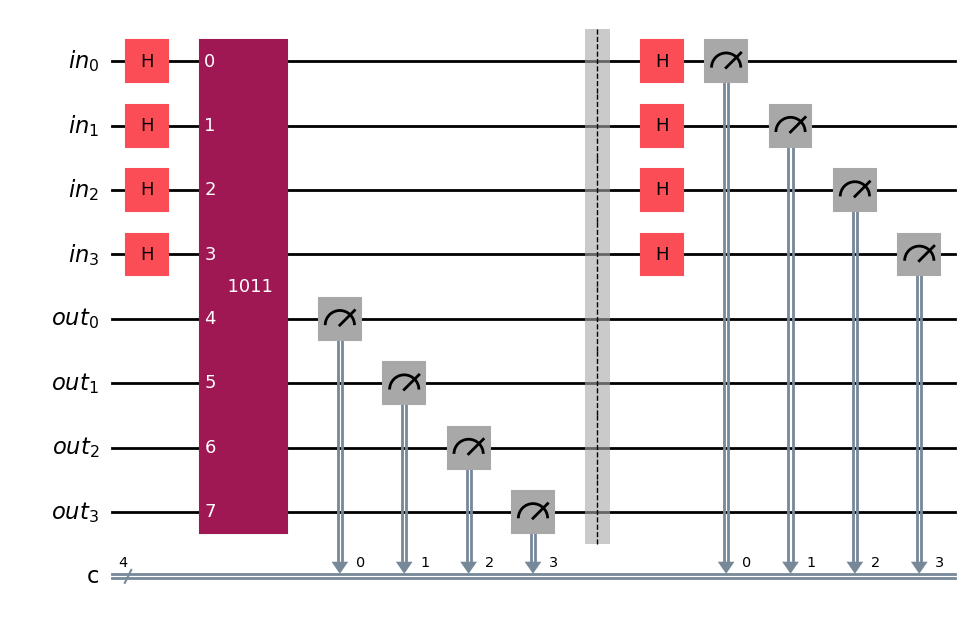

In [ ]:
def simon_circuit(s:str):
    n = len(s)
    inp = QuantumRegister(n, 'in')
    out = QuantumRegister(n, 'out')
    c = ClassicalRegister(n, 'c')
    qc = QuantumCircuit(inp, out, c)
    qc.h(inp)
    qc.compose(oracle_two_to_one(s), inplace=True)
    qc.measure(out, c)
    qc.barrier()
    qc.h(inp)
    qc.measure(inp, c)
    return qc

simon_circuit('1011').draw('mpl')

In [ ]:
fq.run(simon_circuit('1011'), 4)

Un output possibile è
```
{'1001': 1, '0000': 1, '1101': 1, '1110': 1}
```

$$
\begin{cases}
1001 \cdot s = 0\\
0000 \cdot s = 0\\
1101 \cdot s = 0\\
1110 \cdot s = 0
\end{cases}

\Rightarrow

\begin{cases}
(1\cdot s_1)\oplus (0\cdot s_2)\oplus(0\cdot s_3)\oplus (1\cdot s_4)  = 0\\
(0\cdot s_1)\oplus (0\cdot s_2)\oplus(0\cdot s_3)\oplus (0\cdot s_4)  = 0\\
(1\cdot s_1)\oplus (1\cdot s_2)\oplus(0\cdot s_3)\oplus (1\cdot s_4)  = 0\\
(1\cdot s_1)\oplus (1\cdot s_2)\oplus(1\cdot s_3)\oplus (0\cdot s_4)  = 0
\end{cases}

\Rightarrow

\begin{cases}
s_1\oplus 0 \oplus 0 \oplus s_4  = 0\\
0 = 0\\
s_1\oplus s_2\oplus0\oplus s_4  = 0\\
s_1\oplus s_2\oplus s_3 \oplus 0  = 0
\end{cases}
$$

$$
\Rightarrow

\begin{cases}
s_1 = s_4\\
0 = 0\\
s_4\oplus s_2\oplus0\oplus s_4  = 0\\
s_4\oplus s_2\oplus s_3 \oplus 0  = 0
\end{cases}

\Rightarrow

\begin{cases}
s_1 = s_4\\
0 = 0\\
s_2  = 0\\
s_4\oplus s_2\oplus s_3 \oplus 0  = 0
\end{cases}

\Rightarrow

\begin{cases}
s_1 = s_4\\
0 = 0\\
s_2  = 0\\
s_4\oplus s_3 \oplus 0  = 0
\end{cases}

\Rightarrow

\begin{cases}
s_1 = s_4\\
0 = 0\\
s_2  = 0\\
s_4  = s_3
\end{cases}
$$

Sappiamo quindi che la stringa finale è $s = s_1s_2s_3s_4$. Sapendo che $s_2 = 0$ e che $s_1 = s_3 = s_4$, possiamo escludere $s = 0000$, e sappiamo quindi che la stringa è

$$
s = 1011
$$